***
# <font color="#689C73">Multi-Factor Transaction Monitoring and Fraud Risk Analysis</font> 
### **S. Taylor**
***

## <font color="#689C73">Project Introduction</font>

This project analyzes a bank transaction dataset to identify patterns in customer behavior and flag potentially fraudulent activity. By integrating transaction-level, account-level, and customer-related attributes, the analysis provides insights into spending habits, temporal activity, and high-risk transactions, supporting both behavioral understanding and fraud detection.

***
## <font color="#689C73">Project Objective</font>

The objective of this project is to systematically explore and understand transaction data to identify potential fraud and high-risk behavior. The analysis is organized into three main stages:

1. [**Data Overview & Understanding**](#sec_1)  
   - Examine the bank transaction dataset (`bank_transactions_data_df`) to understand the structure, variables, and context  
   - Identify key metrics such as transaction amounts, types, channels, and account-level summaries  
<br>
2. [**Exploratory Data Analysis (EDA)**](#sec_2)
   - Analyze transaction-level distributions, including transaction amounts, types, and channels  
   - Explore temporal patterns such as monthly transaction activity and high-frequency periods  
   - Examine account-level behavior, including high-activity accounts, total spending, and transaction frequency  
<br>
3. [**Fraud Risk Analysis & Scoring**](#sec_3) 
   - Develop a multi-factor scoring system to identify potentially fraudulent transactions  
   - Metrics include high-value transaction flags, transaction frequency spikes, and anomalous login attempts  
   - Assign risk labels (`LOW`, `MEDIUM`, `HIGH`) based on combined scores  
   - Highlight high-risk transactions and accounts for further investigation

***
## <font color="#689C73">Setup</font>

**Data Source:**  
- CSV of bank transaction data [(`bank_transactions_data.csv`)](https://www.kaggle.com/datasets/valakhorasani/bank-transaction-dataset-for-fraud-detection)

**Tools & Libraries:**  
- Python: `pandas`, `matplotlib`, `seaborn`, `sqlite3` 
- SQL: SQLite3, `%sql` magic in Jupyter Notebook (`ipython-sql`)  
- Jupyter Notebook for interactive analysis and visualization  
- Additional Python utilities: `csv`, `IPython.display` for table formatting

**Setup & Installation:** 
- The CSV file is loaded into a Pandas DataFrame and written to a local SQLite database (`FraudDB.db`).  
- A SQLite connection is established to enable SQL-based data transformations and aggregations alongside Python analysis.
- Python visualization style is set with Seaborn (`whitegrid`) and a consistent color palette for charts.  
- `%load_ext sql` is used to enable SQL magic commands in the notebook for seamless querying.

In [34]:
%%capture
!pip install pandas ipython-sql
import csv, sqlite3, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np
from IPython.display import display

con = sqlite3.connect("FraudDB.db")
cur = con.cursor()

%load_ext sql
%sql sqlite:///FraudDB.db

In [45]:
# Set style
sns.set_style("whitegrid")
#palette = sns.color_palette(palette='YlGn')
palette = ['#AA8B83', '#A0C1AC', '#72ABA6', '#51838F', '#C8B39C']

***
## **<font color="#689C73">Data Overview</font>**
### `bank_transactions_data_df` | [Bank Transaction Dataset for Fraud Detection Data](https://www.kaggle.com/datasets/valakhorasani/bank-transaction-dataset-for-fraud-detection)

This dataset contains bank transaction data intended for fraud detection research and financial behavior analysis. It includes transaction-level, account-level, and customer-related attributes, but does **not** contain an explicit fraud label.

| Column Name | Description |
|:---------------|------------:|
| `transactionid` | Unique identifier for each transaction |
| `accountid` | Unique identifier for the customer account |
| `transactionamount` | Monetary value of the transaction |
| `transactiondate` | Date and time when the transaction occurred |
| `transactiontype` | Type of transaction (e.g., debit, credit, transfer) |
| `location` | Geographic location where the transaction took place |
| `deviceid` | Identifier of the device used to perform the transaction |
| `ip_address` | IP address associated with the transaction |
| `merchantid` | Identifier for the merchant involved in the transaction |
| `channel` | Channel used for the transaction (e.g., online, ATM, branch) |
| `customerage` | Age of the account holder |
| `customeroccupation` | Occupation category of the account holder |
| `transactionduration` | Duration of the transaction process |
| `loginattempts` | Number of login attempts prior to the transaction |
| `accountbalance` | Account balance at the time of the transaction |
| `previoustransactiondate` | Timestamp of the previous transaction for the account |

In [3]:
%%capture
bank_transactions_data_df = pd.read_csv("bank_transactions_data.csv")
bank_transactions_data_df.to_sql("bank_transactions_data", con, if_exists='replace', index=False, method="multi")

<a class="anchor" id="sec_1"></a>
***
## **<font color="#689C73">Data Structure & Schema</font>**
This section examines the `bank_transactions_data_df` dataset to understand the structure, completeness, and key metrics. The focus is on checking data integrity, calculating summary statistics, and visualizing transaction distributions to identify trends and potential anomalies.

### Data Integrity Check
**Key Takeaways:**  
- No missing values were found in any of the transaction, account, or customer-related fields.  
- This ensures that downstream analysis can rely on complete records without additional imputation.

In [20]:
%%sql
SELECT *
FROM bank_transactions_data
WHERE TransactionID IS NULL
   OR AccountID IS NULL
   OR TransactionAmount IS NULL
   OR TransactionDate IS NULL
   OR TransactionType IS NULL
   OR Location IS NULL
   OR DeviceID IS NULL
   OR "IP Address" IS NULL
   OR MerchantID IS NULL
   OR Channel IS NULL
   OR CustomerAge IS NULL
   OR CustomerOccupation IS NULL
   OR TransactionDuration IS NULL
   OR LoginAttempts IS NULL
   OR AccountBalance IS NULL
   OR PreviousTransactionDate IS NULL;

 * sqlite:///FraudDB.db
Done.


TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate


### Schema Overview
**Key Takeaways:**  
- The dataset includes 16 columns covering transaction details, account attributes, and customer information.  
- Column types are consistent with expectations (`TEXT` for identifiers and timestamps, `REAL` for amounts, `INTEGER` for age and login attempts).  

In [5]:
%%sql
PRAGMA table_info(bank_transactions_data);

 * sqlite:///FraudDB.db
Done.


cid,name,type,notnull,dflt_value,pk
0,TransactionID,TEXT,0,None,0
1,AccountID,TEXT,0,None,0
2,TransactionAmount,REAL,0,None,0
3,TransactionDate,TEXT,0,None,0
4,TransactionType,TEXT,0,None,0
5,Location,TEXT,0,None,0
6,DeviceID,TEXT,0,None,0
7,IP Address,TEXT,0,None,0
8,MerchantID,TEXT,0,None,0
9,Channel,TEXT,0,None,0


### Transaction Amount Distribution
**Key Takeaways:**  
- Transaction amounts are right-skewed: the **mean (\\$297.59)** exceeds the **median (\\$211.14)**.  
- Transactions range from **\\$0.26 to \\$1,919.11**.  
- The distribution shows concentration in lower-dollar ranges but a long tail of high-value transactions.

In [33]:
%%capture
%%sql shape_result <<
SELECT
  CASE
    WHEN TransactionAmount < 50 THEN '< $50'
    WHEN TransactionAmount < 100 THEN '$50–99'
    WHEN TransactionAmount < 200 THEN '$100–199'
    WHEN TransactionAmount < 300 THEN '$200–299'
    WHEN TransactionAmount < 500 THEN '$300–499'
    WHEN TransactionAmount < 1000 THEN '$500–999'
    ELSE '$1000+'
  END AS "Transaction Amount",
  COUNT(*) AS Transactions
FROM bank_transactions_data
GROUP BY "Transaction Amount"
ORDER BY
  CASE
    WHEN "Transaction Amount" = '< $50' THEN 1
    WHEN "Transaction Amount" = '$50–99' THEN 2
    WHEN "Transaction Amount" = '$100–199' THEN 3
    WHEN "Transaction Amount" = '$200–299' THEN 4
    WHEN "Transaction Amount" = '$300–499' THEN 5
    WHEN "Transaction Amount" = '$500–999' THEN 6
    ELSE 7
  END;

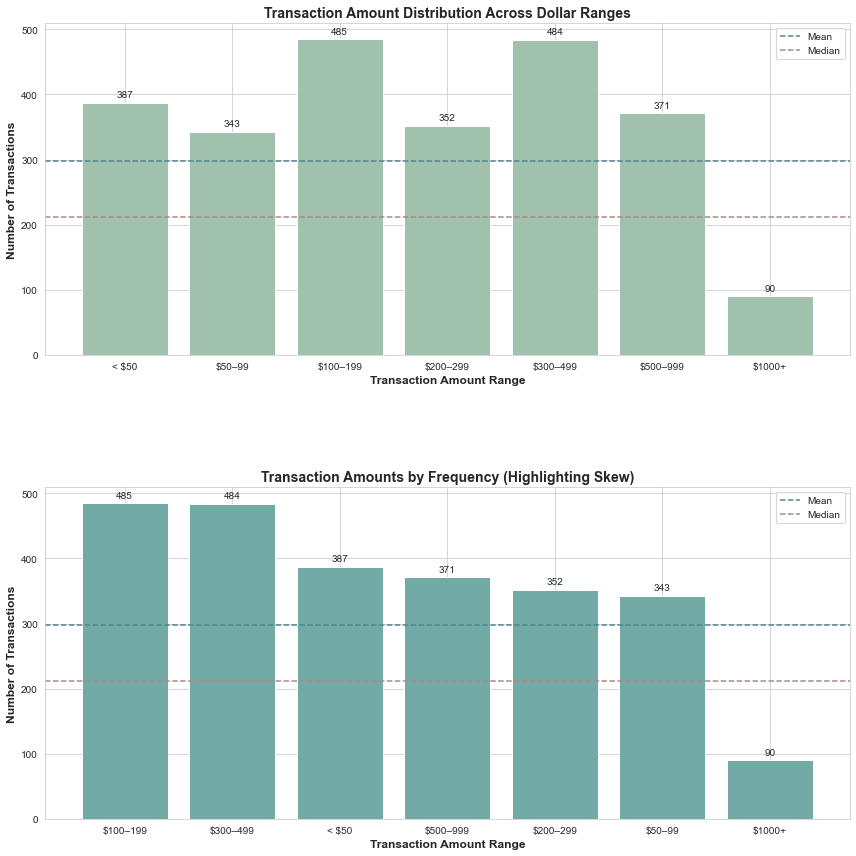

In [66]:
TA_mean = round(bank_transactions_data_df['TransactionAmount'].mean(), 2)
TA_median = round(bank_transactions_data_df['TransactionAmount'].median(), 2)

# Extract labels and counts from SQL result
labels = [row[0] for row in shape_result]
counts = [row[1] for row in shape_result]

# Sort by count descending for skewed view
sorted_pairs = sorted(zip(counts, labels), reverse=True)
sorted_counts, sorted_labels = zip(*sorted_pairs)

# Create vertical subplots (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(12,12))

# Histogram 1: original bin order
bars1 = axes[0].bar(labels, counts, color=palette[1])
axes[0].axhline(y=TA_mean, color=palette[3], linestyle='--', label='Mean')
axes[0].axhline(y=TA_median, color=palette[0], linestyle='--', label='Median')
axes[0].set_title("Transaction Amount Distribution Across Dollar Ranges", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Transaction Amount Range", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Number of Transactions", fontsize=12, fontweight='bold')
axes[0].legend()

# Histogram 2: sorted by frequency (true skew)
bars2 = axes[1].bar(sorted_labels, sorted_counts, color=palette[2])
axes[1].axhline(y=TA_mean, color=palette[3], linestyle='--', label='Mean')
axes[1].axhline(y=TA_median, color=palette[0], linestyle='--', label='Median')
axes[1].set_title("Transaction Amounts by Frequency (Highlighting Skew)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Transaction Amount Range", fontsize=12, fontweight='bold')
axes[1].set_ylabel("Number of Transactions", fontsize=12, fontweight='bold')
axes[1].legend()

# Annotate counts on top of bars
for bar, count in zip(bars1, counts):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, str(count),
                 ha='center', va='bottom', fontsize=10)

# Annotate counts on top of bars
for bar, count in zip(bars2, sorted_counts):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, str(count),
                 ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # adjust the vertical space between the two plots
plt.show()

<a class="anchor" id="sec_2"></a>
***
## <font color="#689C73">Exploratory Data Analysis (EDA)</font>

This section explores transaction-level distributions, categorical patterns, temporal activity, and account-level behavior. The goal is to uncover trends, identify high-risk patterns, and summarize customer transaction behavior.


### Transaction Summary Statistics
**Key Takeaways:**  
- Total transactions: 2,512 across 495 accounts.  
- Transaction amounts range from \\$0.26 to \\$1,919.11.  
- The mean (\\$297.59) is higher than the median (\\$211.14), confirming a **right-skewed distribution**.

In [32]:
%%sql
SELECT 
    COUNT(*) as 'Transaction Count',
    COUNT(DISTINCT(AccountID)) as 'Account Count',
    COUNT(DISTINCT("IP Address")) as 'IP Address Count',
    MIN(TransactionAmount) as 'Min Transaction Amount',
    ROUND(AVG(TransactionAmount),2) as 'Avg Transaction Amount',
    ROUND((
        SELECT AVG(TransactionAmount) 
        FROM (
            SELECT TransactionAmount
            FROM bank_transactions_data
            ORDER BY TransactionAmount
            LIMIT 2 - (SELECT COUNT(*) FROM bank_transactions_data) % 2
            OFFSET (SELECT (COUNT(*) - 1) / 2 FROM bank_transactions_data)
        )
    ), 2) AS 'Mdn Transaction Amount',
    MAX(TransactionAmount) as 'Max Transaction Amount'
FROM bank_transactions_data;

 * sqlite:///FraudDB.db
Done.


Transaction Count,Account Count,IP Address Count,Min Transaction Amount,Avg Transaction Amount,Mdn Transaction Amount,Max Transaction Amount
2512,495,592,0.26,297.59,211.14,1919.11


### Categorical Transaction Patterns
**Key Takeaways:**  
- **Transaction Type:** Most transactions are **Debit (1,944)** versus **Credit (568)**, reflecting typical spending patterns.  
- **Location:** Top transaction locations include **Fort Worth (70)**, **Los Angeles (69)**, **Oklahoma City (68)**, **Charlotte (68)**, and **Tucson (67)**, indicating regional transaction hotspots.  
- **Channel:** Majority occur at **Branches (868)**, followed by **ATM (833)** and **Online (811)**, showing a mix of physical and digital banking activity.

In [24]:
%%sql
SELECT TransactionType, COUNT(*) AS 'Order Count'
FROM bank_transactions_data
GROUP BY TransactionType
ORDER BY "Order Count" DESC;

 * sqlite:///FraudDB.db
Done.


TransactionType,Order Count
Debit,1944
Credit,568


In [27]:
%%sql
SELECT Location, COUNT(*) AS 'Order Count'
FROM bank_transactions_data
GROUP BY Location
ORDER BY "Order Count" DESC
LIMIT 15;

 * sqlite:///FraudDB.db
Done.


Location,Order Count
Fort Worth,70
Los Angeles,69
Oklahoma City,68
Charlotte,68
Tucson,67
Philadelphia,67
Omaha,65
Miami,64
Memphis,63
Houston,63


In [26]:
%%sql
SELECT Channel, COUNT(*) AS 'Order Count'
FROM bank_transactions_data
GROUP BY Channel
ORDER BY "Order Count" DESC;

 * sqlite:///FraudDB.db
Done.


Channel,Order Count
Branch,868
ATM,833
Online,811


### Temporal Activity Patterns
**Key Takeaways:**  
- Monthly transaction counts fluctuate between **161–226** transactions in 2023, with a small start in January 2024 (**13 transactions**).  
- Patterns indicate consistent activity with seasonal and monthly variations.

In [28]:
%%sql
SELECT STRFTIME('%Y-%m', TransactionDate) AS YearMonth, 
       COUNT(*) AS 'Order Count'
FROM bank_transactions_data
GROUP BY YearMonth
ORDER BY YearMonth;

 * sqlite:///FraudDB.db
Done.


YearMonth,Order Count
2023-01,207
2023-02,218
2023-03,197
2023-04,161
2023-05,220
2023-06,212
2023-07,195
2023-08,224
2023-09,214
2023-10,226


### Account-Level Behavior
**Key Takeaways:**  
- Accounts are grouped by transaction frequency to highlight behavioral concentration.  
- Most accounts perform **2–4 transactions (186 accounts)** or **5–9 transactions (272 accounts)**, with fewer accounts in the extremes (1 transaction: 24 accounts; 10–14 transactions: 13 accounts).

In [33]:
%%sql
SELECT
  AccountID,
  COUNT(*) AS Transaction_Count
FROM bank_transactions_data
GROUP BY AccountID;
SELECT
  CASE
    WHEN Transaction_Count < 2 THEN '1'
    WHEN Transaction_Count < 5 THEN '2–4'
    WHEN Transaction_Count < 10 THEN '5–9'
    WHEN Transaction_Count < 15 THEN '10–14'
    ELSE '15+'
  END AS "Transaction Count Range",
  COUNT(*) AS "Accounts"
FROM (
  SELECT AccountID, COUNT(*) AS Transaction_Count
  FROM bank_transactions_data
  GROUP BY AccountID
)
GROUP BY "Transaction Count Range"
ORDER BY 
  CASE
    WHEN "Transaction Count Range" = '1' THEN 1
    WHEN "Transaction Count Range" = '2–4' THEN 2
    WHEN "Transaction Count Range" = '5–9' THEN 3
    WHEN "Transaction Count Range" = '10–14' THEN 4
    ELSE 5
  END;

 * sqlite:///FraudDB.db
Done.
Done.


Transaction Count Range,Accounts
1,24
2–4,186
5–9,272
10–14,13


### High-Activity Accounts
**Key Takeaways:**  
- The top 15 accounts by total spent show **diverse ages and occupations**, including Students, Engineers, and Doctors.  
- Highest total spent: **\\$5,570.34** (12 transactions).  
- These accounts also exhibit high average transaction amounts and login activity, suggesting high engagement or monitoring priority.

In [36]:
%%sql
SELECT 
    AccountID, 
    CustomerAge,
    CustomerOccupation,
    ROUND(SUM(TransactionAmount),2) AS 'Total Spent',
    ROUND(AVG(TransactionAmount),2) AS 'Avg Transaction',
    COUNT(TransactionID) AS 'Total Transactions',
    SUM(LoginAttempts) AS 'Total Login Attempts',
    ROUND(AVG(TransactionDuration),1) AS 'Avg Duration'
FROM bank_transactions_data
GROUP BY AccountID
ORDER BY "Total Spent" DESC
LIMIT 15;

 * sqlite:///FraudDB.db
Done.


AccountID,CustomerAge,CustomerOccupation,Total Spent,Avg Transaction,Total Transactions,Total Login Attempts,Avg Duration
AC00460,25,Student,5570.34,464.2,12,14,115.3
AC00363,29,Engineer,4702.91,391.91,12,12,118.2
AC00337,23,Student,4393.41,549.18,8,8,106.8
AC00021,58,Engineer,4263.34,532.92,8,8,131.5
AC00439,19,Student,4185.81,465.09,9,11,133.8
AC00385,55,Doctor,4141.2,591.6,7,7,124.9
AC00071,18,Student,4050.12,506.27,8,16,110.8
AC00265,20,Student,3953.6,439.29,9,9,103.1
AC00136,58,Doctor,3880.53,485.07,8,8,61.0
AC00179,73,Retired,3819.73,636.62,6,6,133.5


<a class="anchor" id="sec_3"></a>
***
## <font color="#689C73">Fraud Risk Analysis & Scoring</font>

This section analyzes transactions to detect potential fraud using high-value, frequency, and login-based metrics. A multi-factor scoring approach is applied to classify transactions into **LOW**, **MEDIUM**, or **HIGH** fraud risk categories. The goal is to identify anomalous behavior and accounts requiring further investigation.

### Multi-Factor Fraud Metric Creation
**Key Takeaways:**  
- Created `FraudMetricsWithScores` table combining **HighValue**, **FrequencySpike**, and **LoginSpike** indicators.  
- Each transaction receives a **MultiFactorScore** (0–3) and **MultiFactorLabel** (`LOW`, `MEDIUM`, `HIGH`).  
- High-value flags identify transactions exceeding **3× average transaction amount** per account.  
- Frequency flags detect days with **>2× average daily transactions**.  
- Login spikes are flagged when **login attempts >3× account average**.

In [76]:
%%capture
%%sql
DROP TABLE IF EXISTS FraudMetricsWithScores;

In [77]:
%%capture
%%sql
CREATE TABLE FraudMetricsWithScores AS
WITH HighValue AS (
    SELECT
        TransactionID,
        AccountID,
        TransactionDate,
        TransactionAmount,
        ROUND(AVG(TransactionAmount) OVER (PARTITION BY AccountID),2) AS AvgTransactionAmount,
        CASE
            WHEN TransactionAmount > 3 * AVG(TransactionAmount) OVER (PARTITION BY AccountID) THEN 'FLAG'
            ELSE 'NORMAL'
        END AS HighValueStatus
    FROM bank_transactions_data
),
FrequencySpike AS (
    SELECT
        AccountID,
        DATE(TransactionDate) AS TransactionDate,
        COUNT(TransactionID) AS TransactionsPerDay,
        ROUND(AVG(COUNT(TransactionID)) OVER (PARTITION BY AccountID),2) AS AvgDailyTransactions,
        -- Flag days with >2× average daily transactions
        CASE
            WHEN COUNT(TransactionID) > 2 * AVG(COUNT(TransactionID)) OVER (PARTITION BY AccountID) THEN 'FLAG'
            ELSE 'NORMAL'
        END AS FrequencyStatus
    FROM bank_transactions_data
    GROUP BY AccountID, DATE(TransactionDate)
),
LoginSpike AS (
    SELECT
        TransactionID,
        AccountID,
        LoginAttempts,
        ROUND(AVG(LoginAttempts) OVER (PARTITION BY AccountID),2) AS AvgLoginAttempts,
        CASE
            WHEN LoginAttempts > 3 * AVG(LoginAttempts) OVER (PARTITION BY AccountID) THEN 'FLAG'
            ELSE 'NORMAL'
        END AS LoginStatus
    FROM bank_transactions_data
)
SELECT
    h.TransactionID,
    h.AccountID,
    h.TransactionAmount,
    h.AvgTransactionAmount,
    h.HighValueStatus,
    f.TransactionDate,
    f.TransactionsPerDay,
    f.AvgDailyTransactions,
    f.FrequencyStatus,
    l.LoginAttempts,
    l.AvgLoginAttempts,
    l.LoginStatus,
    (CASE WHEN h.HighValueStatus = 'FLAG' THEN 1 ELSE 0 END
   + CASE WHEN f.FrequencyStatus = 'FLAG' THEN 1 ELSE 0 END
   + CASE WHEN l.LoginStatus = 'FLAG' THEN 1 ELSE 0 END) AS MultiFactorScore,
    CASE 
        WHEN (CASE WHEN h.HighValueStatus = 'FLAG' THEN 1 ELSE 0 END
           + CASE WHEN f.FrequencyStatus = 'FLAG' THEN 1 ELSE 0 END
           + CASE WHEN l.LoginStatus = 'FLAG' THEN 1 ELSE 0 END) = 0 THEN 'LOW'
        WHEN (CASE WHEN h.HighValueStatus = 'FLAG' THEN 1 ELSE 0 END
           + CASE WHEN f.FrequencyStatus = 'FLAG' THEN 1 ELSE 0 END
           + CASE WHEN l.LoginStatus = 'FLAG' THEN 1 ELSE 0 END) = 1 THEN 'MEDIUM'
        ELSE 'HIGH'
    END AS MultiFactorLabel
FROM HighValue h
LEFT JOIN FrequencySpike f 
   ON h.AccountID = f.AccountID 
   AND DATE(h.TransactionDate) = f.TransactionDate
JOIN LoginSpike l
    ON h.TransactionID = l.TransactionID;

In [79]:
sql_query = "SELECT * FROM FraudMetricsWithScores"
FraudMetricsWithScores_df = pd.read_sql(sql_query, con=con)

### Fraud Flags Summary
**Key Takeaways:**  
- **High-value flags:** 62 transactions.  
- **Frequency flags:** 0 transactions (no extreme spikes detected).  
- **Login spike flags:** 5 transactions.  
- Indicates that high-value and login anomalies are primary drivers of fraud risk in this dataset.

In [71]:
%%capture
%%sql flags_counts << 
SELECT
    SUM(CASE WHEN HighValueStatus = 'FLAG' THEN 1 ELSE 0 END) AS HighValueFlagCount,
    SUM(CASE WHEN FrequencyStatus = 'FLAG' THEN 1 ELSE 0 END) AS FrequencyFlagCount,
    SUM(CASE WHEN LoginStatus = 'FLAG' THEN 1 ELSE 0 END) AS LoginFlagCount
FROM FraudMetricsWithScores;

In [70]:
flags_counts

HighValueFlagCount,FrequencyFlagCount,LoginFlagCount
62,0,5


### Fraud Flags by Type

This chart shows the composition of fraud flags in the dataset. Each slice represents the proportion of flagged transactions due to high-value transactions, frequency spikes, or anomalous login attempts. The legend clearly maps colors to flag types, highlighting which risk factors contribute most to flagged activity.

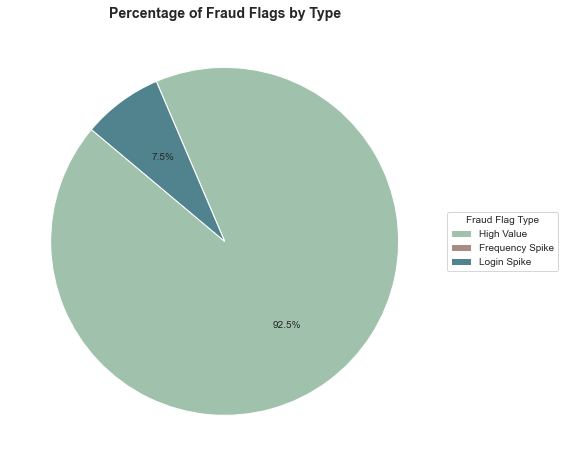

In [133]:
# Flatten the SQL result to counts
flag_counts = list(flags_counts[0])
flag_labels = ['High Value', 'Frequency Spike', 'Login Spike']

# Pie chart with legend instead of slice labels
plt.figure(figsize=(8,8))
wedges, texts, autotexts = plt.pie(
    flag_counts,
    labels=None,  # no labels on slices
    autopct=lambda p: f'{p:.1f}%' if p > 0 else '',  # optional percentages inside slices
    startangle=140,
    colors=[palette[1], palette[0], palette[3]]
)

# Add a legend (key)
plt.legend(wedges, flag_labels, title="Fraud Flag Type", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Percentage of Fraud Flags by Type", fontsize=14, fontweight='bold')
plt.show()

### Transactions with Single-Factor Risk
**Key Takeaways:**  
- Transactions with `MultiFactorScore = 1` are labeled **MEDIUM risk**.  
- Most anomalies come from **high-value or login spikes** individually.  
- Example transaction amounts flagged include **\\$341.67, \\$813.78, \\$1,192.95**, showing a range of moderate-risk events.

In [17]:
%%sql
SELECT *
FROM FraudMetricsWithScores
WHERE MultiFactorScore = 1;

 * sqlite:///FraudDB.db
Done.


TransactionID,AccountID,TransactionAmount,AvgTransactionAmount,HighValueStatus,TransactionDate,TransactionsPerDay,AvgDailyTransactions,FrequencyStatus,LoginAttempts,AvgLoginAttempts,LoginStatus,MultiFactorScore,MultiFactorLabel
TX000694,AC00011,733.29,348.32,NORMAL,2023-03-15,1,1.0,NORMAL,5,1.57,FLAG,1,MEDIUM
TX002087,AC00029,1192.95,323.69,FLAG,2023-12-04,1,1.0,NORMAL,1,1.0,NORMAL,1,MEDIUM
TX001137,AC00032,341.67,376.07,NORMAL,2023-03-06,1,1.0,NORMAL,5,1.44,FLAG,1,MEDIUM
TX001840,AC00035,813.78,239.02,FLAG,2023-08-07,1,1.0,NORMAL,1,1.0,NORMAL,1,MEDIUM
TX002080,AC00054,738.94,194.64,FLAG,2023-10-09,1,1.0,NORMAL,1,1.22,NORMAL,1,MEDIUM
TX000219,AC00070,890.24,236.48,FLAG,2023-07-07,1,1.0,NORMAL,1,1.38,NORMAL,1,MEDIUM
TX001248,AC00071,1647.74,506.27,FLAG,2023-12-25,1,1.0,NORMAL,1,2.0,NORMAL,1,MEDIUM
TX000899,AC00083,1531.31,458.9,FLAG,2023-10-23,1,1.0,NORMAL,4,1.5,NORMAL,1,MEDIUM
TX001134,AC00095,1432.02,397.73,FLAG,2023-09-08,1,1.0,NORMAL,1,1.0,NORMAL,1,MEDIUM
TX000341,AC00107,1830.0,596.06,FLAG,2023-03-01,1,1.0,NORMAL,1,1.0,NORMAL,1,MEDIUM


### Transactions with Multi-Factor Risk
**Key Takeaways:**  
- Transactions with `MultiFactorScore > 1` are labeled **HIGH risk**.  
- Example: `TX001214` (Account AC00170, \\$1,192.20) flagged for **high-value + login spike**.  
- These represent the highest priority for review and potential intervention.

In [18]:
%%sql
SELECT *
FROM FraudMetricsWithScores
WHERE MultiFactorScore > 1;

 * sqlite:///FraudDB.db
Done.


TransactionID,AccountID,TransactionAmount,AvgTransactionAmount,HighValueStatus,TransactionDate,TransactionsPerDay,AvgDailyTransactions,FrequencyStatus,LoginAttempts,AvgLoginAttempts,LoginStatus,MultiFactorScore,MultiFactorLabel
TX001214,AC00170,1192.2,247.33,FLAG,2023-12-21,1,1.0,NORMAL,5,1.57,FLAG,2,HIGH


### Transaction Amount Bins by High-Value Status
This section visualizes the distribution of transactions across different amount ranges, highlighting which transactions are flagged as high-value. The stacked bar plot emphasizes both the frequency of transactions per bin and the proportion that are considered high-value.

<Figure size 1080x576 with 0 Axes>

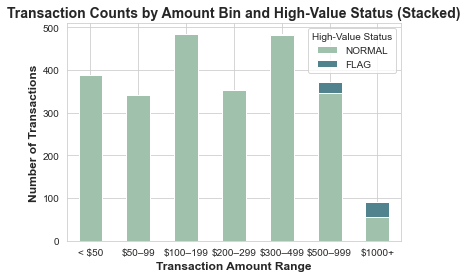

In [130]:
# Pivot data for stacked bars
stacked_data = amount_bin_counts.pivot(
    index='TransactionAmountBin', 
    columns='HighValueStatus', 
    values='TransactionCount'
).fillna(0)

# Reorder columns: NORMAL first (bottom), FLAG second (top)
stacked_data = stacked_data[['NORMAL', 'FLAG']]

# Plot
plt.figure(figsize=(15,8))
stacked_data.plot(
    kind='bar', 
    stacked=True, 
    color=[palette[1], palette[3]]  # NORMAL bottom, FLAG top
)
plt.title("Transaction Counts by Amount Bin and High-Value Status (Stacked)", fontsize=14, fontweight='bold')
plt.xlabel("Transaction Amount Range", fontsize=12, fontweight='bold')
plt.ylabel("Number of Transactions", fontsize=12, fontweight='bold')
plt.legend(title="High-Value Status")
plt.xticks(rotation=0)
plt.show()


### Flagged Transactions Over Time
This section examines the temporal trends of flagged transactions across the dataset. The line chart tracks the total number of flagged transactions per month, providing insights into periods of elevated risk or unusual activity.

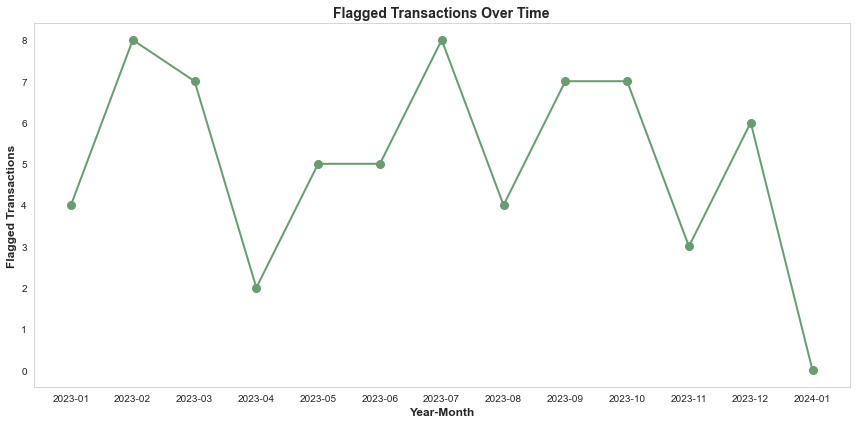

In [131]:
# Ensure TransactionDate is datetime
FraudMetricsWithScores_df['TransactionDate'] = pd.to_datetime(FraudMetricsWithScores_df['TransactionDate'])

# Filter flagged transactions
flagged_df = FraudMetricsWithScores_df[FraudMetricsWithScores_df['MultiFactorScore'] > 0].copy()

# Create YearMonth as period
flagged_df['YearMonth'] = flagged_df['TransactionDate'].dt.to_period('M')

# Create full YearMonth range (all months in dataset)
all_months = pd.period_range(
    start=FraudMetricsWithScores_df['TransactionDate'].min().to_period('M'),
    end=FraudMetricsWithScores_df['TransactionDate'].max().to_period('M'),
    freq='M'
)

# Aggregate flagged counts per month
flagged_agg = flagged_df.groupby('YearMonth').agg(FlaggedTransactions=('TransactionID','count'))

# Reindex to include all months
flagged_agg = flagged_agg.reindex(all_months, fill_value=0).reset_index()
flagged_agg.rename(columns={'index':'YearMonth'}, inplace=True)

# Convert Period back to string for plotting
flagged_agg['YearMonth'] = flagged_agg['YearMonth'].dt.strftime('%Y-%m')

# Plot
plt.figure(figsize=(12,6))
plt.plot(
    flagged_agg['YearMonth'], 
    flagged_agg['FlaggedTransactions'], 
    color='#689C73',
    linewidth=2,
    marker='o',
    markersize=8
)

plt.xlabel("Year-Month", fontsize=12, fontweight='bold')
plt.ylabel("Flagged Transactions", fontsize=12, fontweight='bold')
plt.title("Flagged Transactions Over Time", fontsize=14, fontweight='bold')
plt.grid(False)
plt.tight_layout()
plt.show()

***
## **<font color="#689C73">Conclusion</font>**

The analysis of the `bank_transactions_data_df` dataset provides a comprehensive view of transaction behavior, account activity, and potential fraud risk. By examining transaction amounts, categorical patterns, temporal trends, account-level behavior, and multi-factor fraud scoring, this report highlights key trends and actionable insights for banking analysts and risk managers

**Key Takeaways:**  
- Transaction amounts are right-skewed, with a mean of **\\$297.59** and a median of **\\$211.14**, indicating a concentration of smaller transactions alongside high-value outliers  
- Most transactions are **Debit (1,944)**, with activity concentrated in key locations like **Fort Worth, Los Angeles, and Oklahoma City**, and distributed across **Branch, ATM, and Online channels**, reflecting typical customer behavior  
- Temporal analysis shows monthly fluctuations in transaction volume, with spikes in certain months, and most accounts exhibiting low to moderate transaction frequency  
- High-activity accounts contribute disproportionately to total transaction volume, with some accounts exceeding **\\$5,500** in total spending  
- Multi-factor fraud scoring identifies transactions at **MEDIUM and HIGH risk**, primarily driven by **high-value spikes and abnormal login behavior**, enabling targeted monitoring of anomalous activity

Overall, this analysis equips stakeholders with the insights needed to monitor transaction patterns, identify high-risk accounts, and implement proactive fraud detection measures

**Future Recommendations:**  
- Focus fraud monitoring on high-value transactions and accounts exhibiting abnormal login or frequency patterns  
- Develop targeted alerts for accounts classified as **MEDIUM** or **HIGH risk** to prioritize investigative resources  
- Continue tracking temporal transaction patterns to anticipate high-activity periods and potential spikes in fraudulent activity  
- Maintain rigorous data quality and consistency checks to ensure reliable detection and reporting  
- Consider integrating additional data sources (e.g., external fraud databases, device metadata) to enhance multi-factor risk scoring and predictive accuracy

***